In [1]:
import torch
import os
import numpy as np
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
import matplotlib.pyplot as plt
device = 'cpu'
path = os.path.abspath('../..')
path

'/home/upadesh/3_Codes/6_Au_Au_Laser'

In [2]:

# UNet model definition
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()

        def conv_block(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True)
            )

        ## Highest Paramterer Model
        # self.encoder1 = conv_block(in_channels, 64)
        # self.encoder2 = conv_block(64, 128)
        # self.encoder3 = conv_block(128, 256)
        # self.encoder4 = conv_block(256, 512)

        # self.pool = nn.MaxPool2d(2)

        # self.middle = conv_block(512, 1024)

        # self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        # self.decoder4 = conv_block(1024, 512)
        # self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        # self.decoder3 = conv_block(512, 256)
        # self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        # self.decoder2 = conv_block(256, 128)
        # self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        # self.decoder1 = conv_block(128, 64)

        # self.final = nn.Conv2d(64, out_channels, kernel_size=1)
        ##########################################

        # # Reduced number of filters to make the network light
        # self.encoder1 = conv_block(in_channels, 32)
        # self.encoder2 = conv_block(32, 64)
        # self.encoder3 = conv_block(64, 128)
        # self.encoder4 = conv_block(128, 256)

        # self.pool = nn.MaxPool2d(2)

        # self.middle = conv_block(256, 512)

        # self.upconv4 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        # self.decoder4 = conv_block(512, 256)
        # self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        # self.decoder3 = conv_block(256, 128)
        # self.upconv2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        # self.decoder2 = conv_block(128, 64)
        # self.upconv1 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        # self.decoder1 = conv_block(64, 32)

        # self.final = nn.Conv2d(32, out_channels, kernel_size=1)

        ##########################################
        # Further reduced number of filters to make the network ultra-light
        self.encoder1 = conv_block(in_channels, 16)
        self.encoder2 = conv_block(16, 32)
        self.encoder3 = conv_block(32, 64)
        self.encoder4 = conv_block(64, 128)

        self.pool = nn.MaxPool2d(2)

        self.middle = conv_block(128, 256)

        self.upconv4 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder4 = conv_block(256, 128)
        self.upconv3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder3 = conv_block(128, 64)
        self.upconv2 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.decoder2 = conv_block(64, 32)
        self.upconv1 = nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2)
        self.decoder1 = conv_block(32, 16)

        self.final = nn.Conv2d(16, out_channels, kernel_size=1)
        #########################################


    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool(enc1))
        enc3 = self.encoder3(self.pool(enc2))
        enc4 = self.encoder4(self.pool(enc3))

        middle = self.middle(self.pool(enc4))

        dec4 = self.upconv4(middle)
        dec4 = self.pad_and_crop(enc4, dec4)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)

        dec3 = self.upconv3(dec4)
        dec3 = self.pad_and_crop(enc3, dec3)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)

        dec2 = self.upconv2(dec3)
        dec2 = self.pad_and_crop(enc2, dec2)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)

        dec1 = self.upconv1(dec2)
        dec1 = self.pad_and_crop(enc1, dec1)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)

        out = self.final(dec1)
        return out

    def pad_and_crop(self, target, tensor):
        _, _, target_height, target_width = target.size()
        _, _, tensor_height, tensor_width = tensor.size()

        # Padding
        pad_h = max(0, target_height - tensor_height)
        pad_w = max(0, target_width - tensor_width)

        pad_left = pad_w // 2
        pad_right = pad_w - pad_left
        pad_top = pad_h // 2
        pad_bottom = pad_h - pad_top

        tensor = F.pad(tensor, (pad_left, pad_right, pad_top, pad_bottom), mode='constant', value=0)

        # Cropping
        delta_h = (tensor.size(2) - target_height) // 2
        delta_w = (tensor.size(3) - target_width) // 2

        return tensor[:, :, delta_h: delta_h + target_height, delta_w: delta_w + target_width]

In [3]:
# Custom Dataset Class
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        feature = self.features[idx].clone().detach().requires_grad_(True)
        label = self.labels[idx].clone().detach()
        return feature, label
    
# Function to calculate accuracy (for binary classification)
def calculate_accuracy(output, target):
    preds = torch.sigmoid(output) > 0.5
    correct = (preds == target).float()
    acc = correct.sum() / torch.numel(correct)
    return acc

In [4]:
model = UNet(in_channels=1, out_channels=1).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


In [5]:
model.load_state_dict(torch.load(path+'/6_Machine_Learning/trained_model/model.pth'))
# model

<All keys matched successfully>

## Temperature Only Simulation

In [6]:
X_T = np.load(path+'/1_Simulation_Results/ML_numpy_files/quant_data/temp_only/X.npy')
time_T = np.load(path+'/1_Simulation_Results/ML_numpy_files/quant_data/temp_only/time.npy')

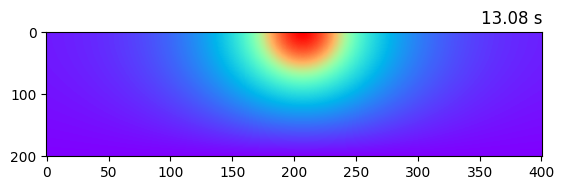

In [7]:
t=201;plt.imshow(X_T[t], aspect=0.5, cmap='rainbow'); plt.title(f'{time_T[t]:.2f} s', loc='right'); plt.show()

In [8]:
XT_reshaped = X_T[:, np.newaxis, :, :]  ## Adding Batch size of 1
XT_reshaped.shape

(384, 1, 201, 401)

In [9]:
XT_reshaped = torch.tensor(XT_reshaped, dtype=torch.float32)
dataset_T = TensorDataset(XT_reshaped)
dataloader_T = DataLoader(dataset_T, batch_size=1, shuffle=False)

In [10]:
model.eval()
with torch.no_grad():
    LIQ_pred_T = np.zeros_like(XT_reshaped)
    for i, inputs in enumerate(dataloader_T):
        inputs = inputs[0].to(device)
        outputs = model(inputs)
        prediction = torch.sigmoid(outputs)
        prediction = (prediction > 0.5).float()
        prediction = prediction.cpu().numpy()
        LIQ_pred_T[i] = prediction[0]

In [11]:
LIQ_pred_T.shape

(384, 1, 201, 401)

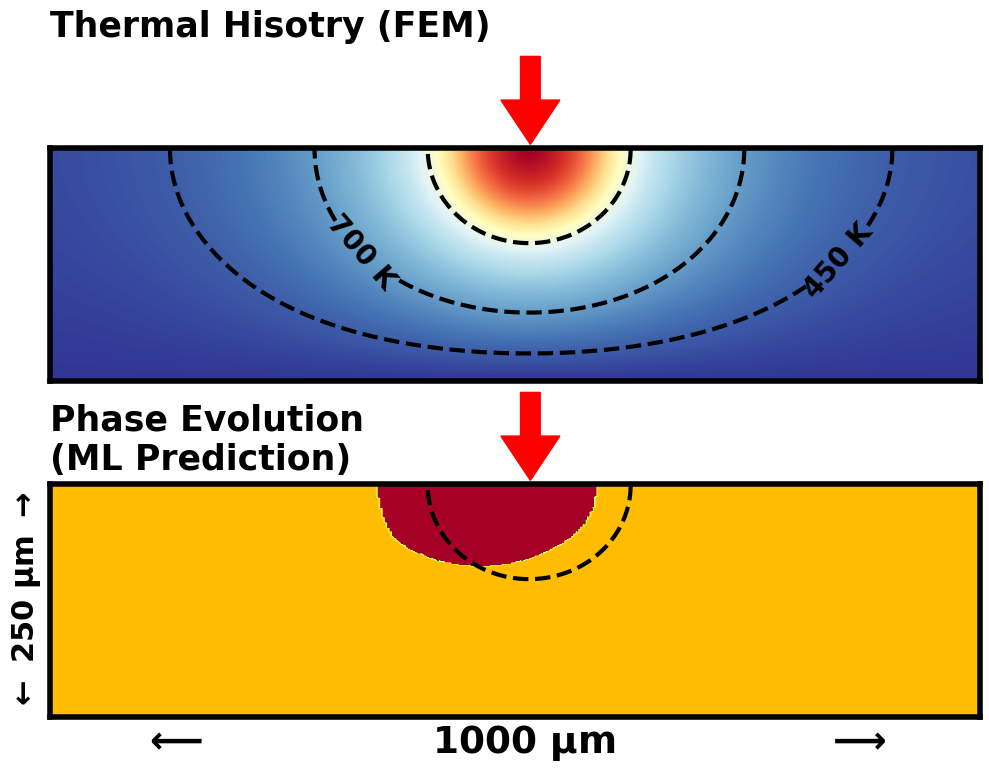

In [12]:
t_step = 200

laser_speed = 30
laser_pos = (125 + time_T[t_step]*laser_speed)* 401/1000  # Laser actual position in true dimension


fig2, (ax1, ax4) = plt.subplots(2, 1, figsize=(12, 8))

cmap = plt.get_cmap('RdYlBu_r')
cmap.set_under('white', alpha=0)
hmap1 = ax1.imshow(XT_reshaped[t_step][0], cmap='RdYlBu_r', vmin=300, aspect=0.5,  interpolation='quadric')
ax1.set_title('Thermal Hisotry (FEM)', pad=80, loc='left', fontsize=25, weight='bold')
ax1.tick_params(axis='both', labelcolor='black', labelsize=65, bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
ax1.arrow(laser_pos, -80, 0, 76,  width = 8.5, color='red', length_includes_head=True, clip_on=False)
ax1.set_ylim(201, -1);  ax1.set_xlim(-1,401)
ax1.spines[:].set_linewidth(4)

contour_levels = [450, 700]
label_colors = ['k', 'k',]
contour = ax1.contour(XT_reshaped[t_step][0], levels=contour_levels, colors='black', linewidths=3, linestyles='dashed')
labels = plt.clabel(contour, inline=True, fontsize=20, fmt='%1.0f K')
for label, color in zip(labels, label_colors): label.set_fontweight('bold');label.set_color(color) 
ax1.spines[:].set_linewidth(4)
ax1.contour(XT_reshaped[t_step][0], levels=[1337], colors='black', linewidths=3, linestyles='dashed')



cmap = plt.get_cmap('RdYlGn_r')
cmap.set_under('white', alpha=0)
hmap4a = ax4.imshow(LIQ_pred_T[t_step][0], cmap=cmap, vmin=0.5, vmax=1.0, aspect=0.5)
cmap = plt.get_cmap('Wistia')
cmap.set_under('white', alpha=0) 
hmap4b = ax4.imshow(1-LIQ_pred_T[t_step][0], cmap=cmap, vmin=0.5, vmax=1.5, aspect=0.5, interpolation='quadric')
ax4.tick_params(axis='both', labelcolor='black', labelsize=65, bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
ax4.arrow(laser_pos, -80, 0, 76,  width = 8.5, color='none', length_includes_head=True, clip_on=False)
ax4.set_ylim(201, -1);  ax4.set_xlim(-1,401)
ax4.set_title('Phase Evolution\n(ML Prediction)', pad=10, loc='left', fontsize=25, weight='bold')
ax4.arrow(laser_pos, -80, 0, 76,  width = 8.5, color='red', length_includes_head=True, clip_on=False)
ax4.set_xlabel('$\mathbf{\longleftarrow}$                 1000 $ \mathbf{\mu m}$                $\mathbf{\longrightarrow}$', fontsize = 27, weight ='bold',)
ax4.annotate(r'$\mathbf{\leftarrow}$ 250 $\mathbf{\mu m}$ $\mathbf{\rightarrow}$', xy=(0.5, 0.5), xytext=(-0.025, 0.5), rotation=90, xycoords='axes fraction', textcoords='axes fraction', fontsize = 22, weight = 'bold', color='k', ha='center', va='center')

ax4.spines[:].set_linewidth(4)
ax4.contour(XT_reshaped[t_step][0], levels=[1337], colors='black', linewidths=3, linestyles='dashed')

plt.show()

In [14]:
# Saving as Predicted Numpy Files
np.save('predicted_results/temp_only/LIQ_pred_T.npy', LIQ_pred_T)

## PF Temperature Simulation

In [15]:
X_PF = np.load(path+'/1_Simulation_Results/ML_numpy_files/quant_data/pf_temp/X.npy')
y_PF = np.load(path+'/1_Simulation_Results/ML_numpy_files/quant_data/pf_temp/y.npy')
time_PF = np.load(path+'/1_Simulation_Results/ML_numpy_files/quant_data/pf_temp/time.npy')

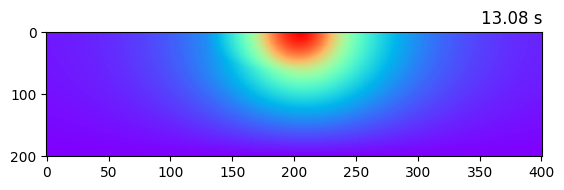

In [16]:
t=201;plt.imshow(X_PF[t], aspect=0.5, cmap='rainbow'); plt.title(f'{time_PF[t]:.2f} s', loc='right'); plt.show()

In [17]:
XPF_reshaped = X_PF[:, np.newaxis, :, :]  ## Adding Batch size of 1
XPF_reshaped.shape

(384, 1, 201, 401)

In [18]:
XPF_reshaped = torch.tensor(XPF_reshaped, dtype=torch.float32)
dataset_PF = TensorDataset(XPF_reshaped)
dataloader_PF = DataLoader(dataset_PF, batch_size=1, shuffle=False)

In [19]:
model.eval()
with torch.no_grad():
    LIQ_pred_PF = np.zeros_like(XPF_reshaped)
    for i, inputs in enumerate(dataloader_PF):
        inputs = inputs[0].to(device)
        outputs = model(inputs)
        prediction = torch.sigmoid(outputs)
        prediction = (prediction > 0.5).float()
        prediction = prediction.cpu().numpy()
        LIQ_pred_PF[i] = prediction[0]

In [20]:
LIQ_pred_PF.shape

(384, 1, 201, 401)

In [21]:
pred_error = LIQ_pred_PF - y_PF[:, np.newaxis, :, :]

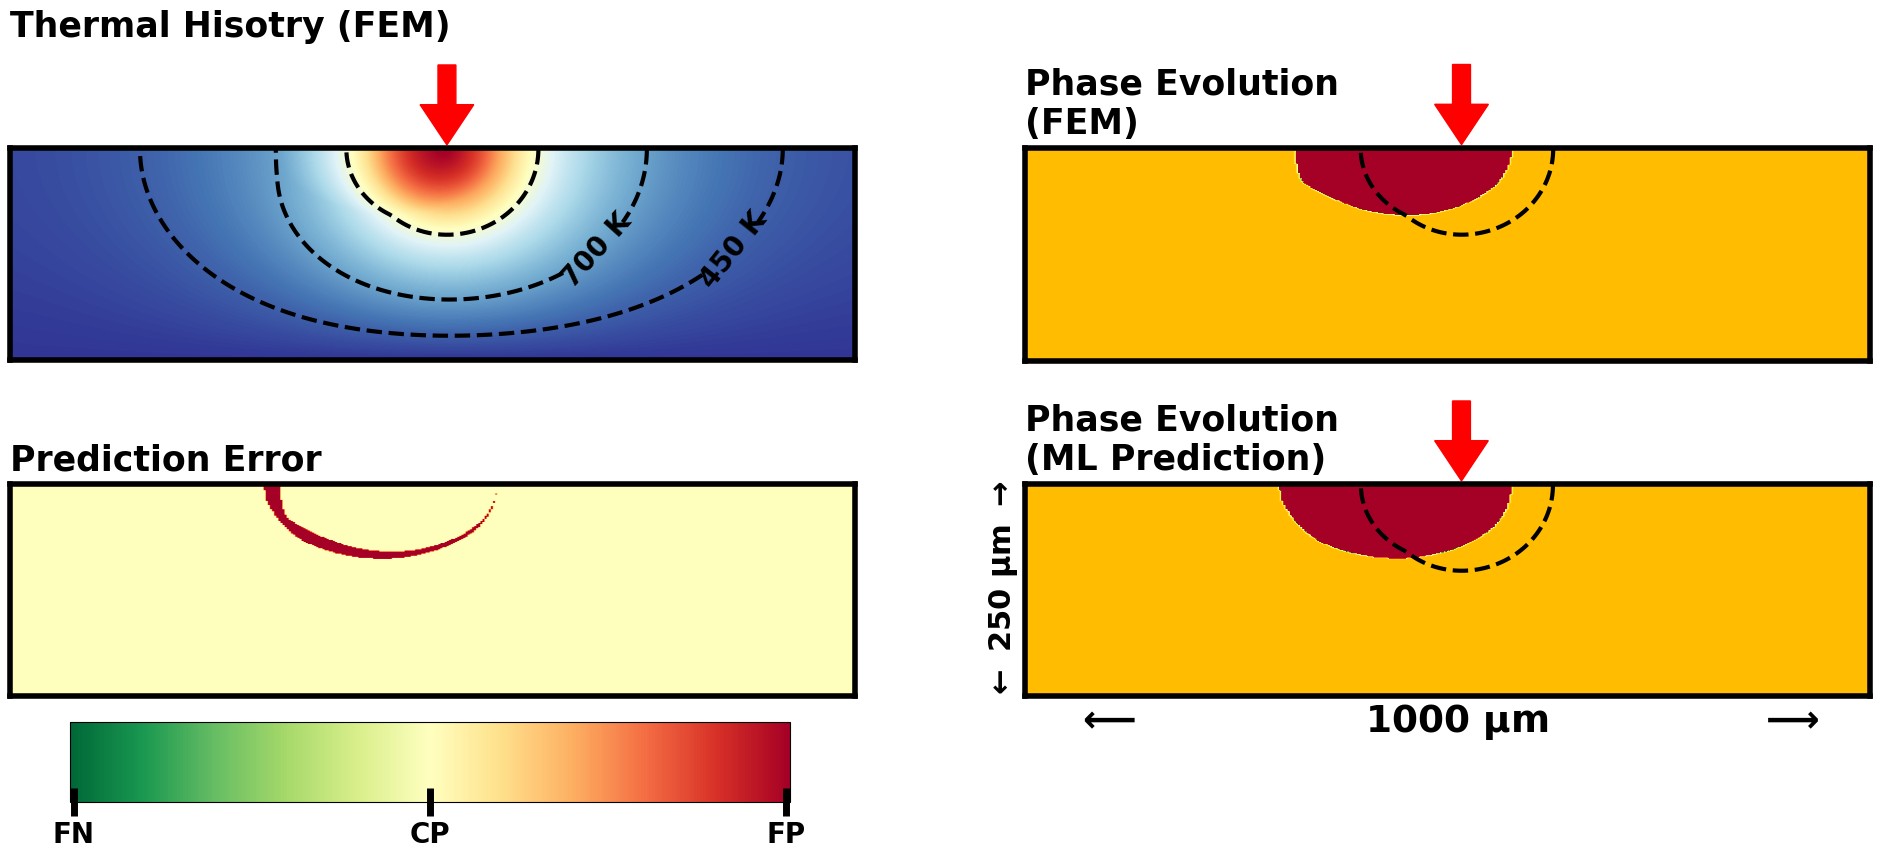

In [22]:
t_step = 200

laser_speed = 30
laser_pos = (125 + time_PF[t_step]*laser_speed)* 401/1000  # Laser actual position in true dimension


fig1, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(24, 8))

cmap = plt.get_cmap('RdYlBu_r')
cmap.set_under('white', alpha=0)
hmap1 = ax1.imshow(XPF_reshaped[t_step][0], cmap='RdYlBu_r', vmin=300, aspect=0.5,  interpolation='quadric')
ax1.set_title('Thermal Hisotry (FEM)', pad=80, loc='left', fontsize=25, weight='bold')
ax1.tick_params(axis='both', labelcolor='black', labelsize=65, bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
ax1.arrow(laser_pos, -80, 0, 76,  width = 8.5, color='red', length_includes_head=True, clip_on=False)
ax1.set_ylim(201, -1);  ax1.set_xlim(-1,401)
ax1.spines[:].set_linewidth(4)

contour_levels = [450, 700]
label_colors = ['k', 'k',]
contour = ax1.contour(XPF_reshaped[t_step][0], levels=contour_levels, colors='black', linewidths=3, linestyles='dashed')
labels = plt.clabel(contour, inline=True, fontsize=20, fmt='%1.0f K')
for label, color in zip(labels, label_colors): label.set_fontweight('bold');label.set_color(color) 
ax1.spines[:].set_linewidth(4)
ax1.contour(XPF_reshaped[t_step][0], levels=[1337], colors='black', linewidths=3, linestyles='dashed')


cmap = plt.get_cmap('RdYlGn_r')
cmap.set_under('white', alpha=0)
hmap2 = ax2.imshow(y_PF[t_step], cmap=cmap, vmin=0.5, vmax=1.0, aspect=0.5)
cmap = plt.get_cmap('Wistia')
cmap.set_under('white', alpha=0) 
hmap2 = ax2.imshow(1-y_PF[t_step], cmap=cmap, vmin=0.5, vmax=1.5, aspect=0.5, interpolation='quadric')
ax2.tick_params(axis='both', labelcolor='black', labelsize=65, bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
ax2.arrow(laser_pos, -80, 0, 76,  width = 8.5, color='none', length_includes_head=True, clip_on=False)
ax2.set_ylim(201, -1);  ax4.set_xlim(-1,401)
ax2.set_title('Phase Evolution\n(FEM)', pad=10, loc='left', fontsize=25, weight='bold')
ax2.arrow(laser_pos, -80, 0, 76,  width = 8.5, color='red', length_includes_head=True, clip_on=False)

ax2.spines[:].set_linewidth(4)
ax2.contour(XPF_reshaped[t_step][0], levels=[1337], colors='black', linewidths=3, linestyles='dashed')


cmap = plt.get_cmap('RdYlGn_r')
cmap.set_under('white', alpha=0)
hmap3 = ax3.imshow(pred_error[t_step][0], cmap=cmap, vmin=-1, vmax=1, aspect=0.5)
ax3.set_title('Prediction Error', pad=10, loc='left', fontsize=25, weight='bold')
ax3.tick_params(axis='both', labelcolor='black', labelsize=65, bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
ax5 = fig1.add_axes([0.15, 0.02, 0.3, 0.1])
cbar = fig1.colorbar(hmap3, cax=ax5, orientation='horizontal')
cbar.ax.tick_params(labelsize=20, direction='inout', length=20, width=5, rotation=0) 
cbar.set_ticks([-0.99,0,0.99], labels=['FN','CP','FP'], weight='bold')
ax3.arrow(laser_pos, -80, 0, 76,  width = 8.5, color='none', length_includes_head=True, clip_on=False)
ax3.set_ylim(201, -1);  ax3.set_xlim(-1,401)
ax3.spines[:].set_linewidth(4)


cmap = plt.get_cmap('RdYlGn_r')
cmap.set_under('white', alpha=0)
hmap4a = ax4.imshow(LIQ_pred_PF[t_step][0], cmap=cmap, vmin=0.5, vmax=1.0, aspect=0.5)
cmap = plt.get_cmap('Wistia')
cmap.set_under('white', alpha=0) 
hmap4b = ax4.imshow(1-LIQ_pred_PF[t_step][0], cmap=cmap, vmin=0.5, vmax=1.5, aspect=0.5, interpolation='quadric')
ax4.tick_params(axis='both', labelcolor='black', labelsize=65, bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
ax4.arrow(laser_pos, -80, 0, 76,  width = 8.5, color='none', length_includes_head=True, clip_on=False)
ax4.set_ylim(201, -1);  ax4.set_xlim(-1,401)
ax4.set_title('Phase Evolution\n(ML Prediction)', pad=10, loc='left', fontsize=25, weight='bold')
ax4.arrow(laser_pos, -80, 0, 76,  width = 8.5, color='red', length_includes_head=True, clip_on=False)
ax4.set_xlabel('$\mathbf{\longleftarrow}$                 1000 $ \mathbf{\mu m}$                $\mathbf{\longrightarrow}$', fontsize = 27, weight ='bold',)
ax4.annotate(r'$\mathbf{\leftarrow}$ 250 $\mathbf{\mu m}$ $\mathbf{\rightarrow}$', xy=(0.5, 0.5), xytext=(-0.025, 0.5), rotation=90, xycoords='axes fraction', textcoords='axes fraction', fontsize = 22, weight = 'bold', color='k', ha='center', va='center')

ax4.spines[:].set_linewidth(4)
ax4.contour(XPF_reshaped[t_step][0], levels=[1337], colors='black', linewidths=3, linestyles='dashed')

plt.show()

In [23]:
# Saving as Predicted Numpy Files
np.save('predicted_results/pf_temp/LIQ_pred_PFT.npy', LIQ_pred_PF)

## Quantification Between Temperature Only Vs PF 

In [24]:
pred_error_PFT = LIQ_pred_T - y_PF[:, np.newaxis, :, :]

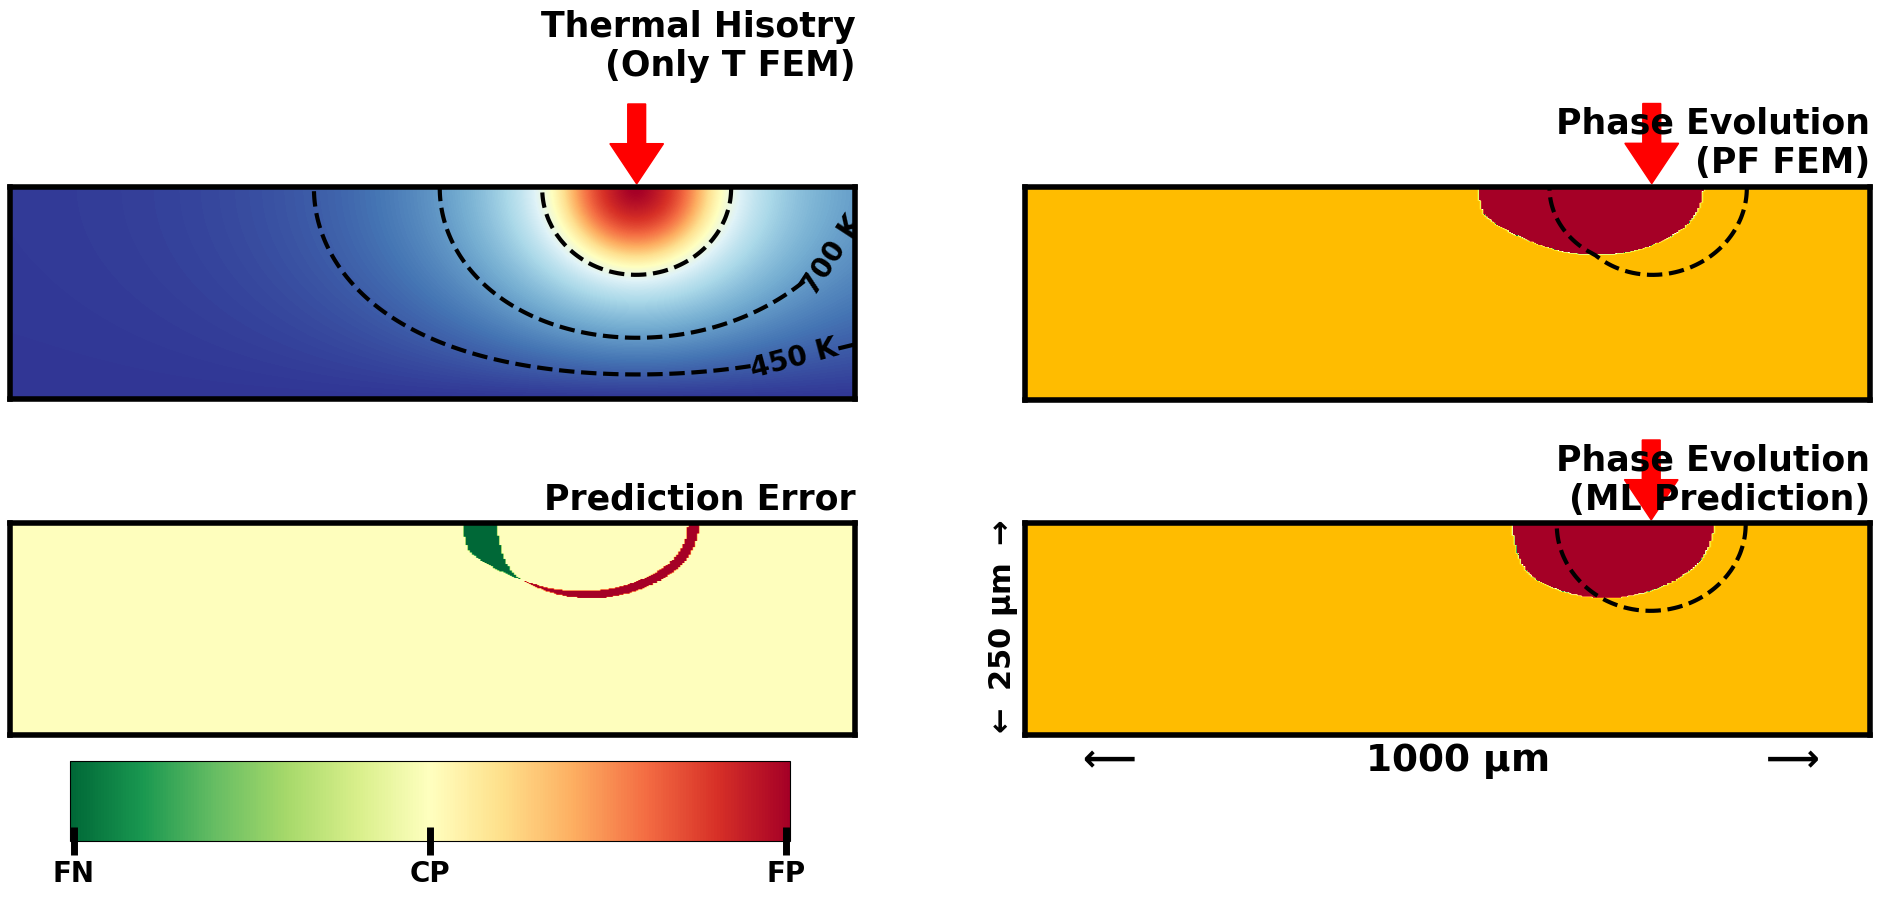

In [29]:
t_step = 325
laser_speed = 30
laser_pos = (125 + time_PF[t_step]*laser_speed)* 401/1000  # Laser actual position in true dimension

fig1, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(24, 8))

cmap = plt.get_cmap('RdYlBu_r')
cmap.set_under('white', alpha=0)
hmap1 = ax1.imshow(XT_reshaped[t_step][0], cmap='RdYlBu_r', vmin=300, aspect=0.5,  interpolation='quadric')
ax1.set_title('Thermal Hisotry\n(Only T FEM)', pad=80, loc='right', fontsize=25, weight='bold')
ax1.tick_params(axis='both', labelcolor='black', labelsize=65, bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
ax1.arrow(laser_pos, -80, 0, 76,  width = 8.5, color='red', length_includes_head=True, clip_on=False)
ax1.set_ylim(201, -1);  ax1.set_xlim(-1,401)
ax1.spines[:].set_linewidth(4)

contour_levels = [450, 700]
label_colors = ['k', 'k',]
contour = ax1.contour(XT_reshaped[t_step][0], levels=contour_levels, colors='black', linewidths=3, linestyles='dashed')
labels = plt.clabel(contour, inline=True, fontsize=20, fmt='%1.0f K')
for label, color in zip(labels, label_colors): label.set_fontweight('bold');label.set_color(color) 
ax1.spines[:].set_linewidth(4)
ax1.contour(XT_reshaped[t_step][0], levels=[1337], colors='black', linewidths=3, linestyles='dashed')


cmap = plt.get_cmap('RdYlGn_r')
cmap.set_under('white', alpha=0)
hmap2 = ax2.imshow(y_PF[t_step], cmap=cmap, vmin=0.5, vmax=1.0, aspect=0.5)
cmap = plt.get_cmap('Wistia')
cmap.set_under('white', alpha=0) 
hmap2 = ax2.imshow(1-y_PF[t_step], cmap=cmap, vmin=0.5, vmax=1.5, aspect=0.5, interpolation='quadric')
ax2.tick_params(axis='both', labelcolor='black', labelsize=65, bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
ax2.arrow(laser_pos, -80, 0, 76,  width = 8.5, color='none', length_includes_head=True, clip_on=False)
ax2.set_ylim(201, -1);  ax4.set_xlim(-1,401)
ax2.set_title('Phase Evolution\n(PF FEM)', pad=10, loc='right', fontsize=25, weight='bold')
ax2.arrow(laser_pos, -80, 0, 76,  width = 8.5, color='red', length_includes_head=True, clip_on=False)

ax2.spines[:].set_linewidth(4)
ax2.contour(XPF_reshaped[t_step][0], levels=[1337], colors='black', linewidths=3, linestyles='dashed')


cmap = plt.get_cmap('RdYlGn_r')
cmap.set_under('white', alpha=0)
hmap3 = ax3.imshow(pred_error_PFT[t_step][0], cmap=cmap, vmin=-1, vmax=1, aspect=0.5)
ax3.set_title('Prediction Error', pad=10, loc='right', fontsize=25, weight='bold')
ax3.tick_params(axis='both', labelcolor='black', labelsize=65, bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
ax5 = fig1.add_axes([0.15, 0.02, 0.3, 0.1])
cbar = fig1.colorbar(hmap3, cax=ax5, orientation='horizontal')
# ax5.tick_params(axis='both', labelcolor='black', labelsize=1, bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
cbar.ax.tick_params(labelsize=20, direction='inout', length=20, width=5, rotation=0) 
cbar.set_ticks([-0.99,0,0.99], labels=['FN','CP','FP'], weight='bold')
ax3.arrow(laser_pos, -80, 0, 76,  width = 8.5, color='none', length_includes_head=True, clip_on=False)
ax3.set_ylim(201, -1);  ax3.set_xlim(-1,401)
ax3.spines[:].set_linewidth(4)


cmap = plt.get_cmap('RdYlGn_r')
cmap.set_under('white', alpha=0)
hmap4a = ax4.imshow(LIQ_pred_T[t_step][0], cmap=cmap, vmin=0.5, vmax=1.0, aspect=0.5)
cmap = plt.get_cmap('Wistia')
cmap.set_under('white', alpha=0) 
hmap4b = ax4.imshow(1-LIQ_pred_T[t_step][0], cmap=cmap, vmin=0.5, vmax=1.5, aspect=0.5, interpolation='quadric')
ax4.tick_params(axis='both', labelcolor='black', labelsize=65, bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
ax4.arrow(laser_pos, -80, 0, 76,  width = 8.5, color='none', length_includes_head=True, clip_on=False)
ax4.set_ylim(201, -1);  ax4.set_xlim(-1,401)
ax4.set_title('Phase Evolution\n(ML Prediction)', pad=10, loc='right', fontsize=25, weight='bold')
ax4.arrow(laser_pos, -80, 0, 76,  width = 8.5, color='red', length_includes_head=True, clip_on=False)
ax4.set_xlabel('$\mathbf{\longleftarrow}$                 1000 $ \mathbf{\mu m}$                $\mathbf{\longrightarrow}$', fontsize = 27, weight ='bold',)
ax4.annotate(r'$\mathbf{\leftarrow}$ 250 $\mathbf{\mu m}$ $\mathbf{\rightarrow}$', xy=(0.5, 0.5), xytext=(-0.025, 0.5), rotation=90, xycoords='axes fraction', textcoords='axes fraction', fontsize = 22, weight = 'bold', color='k', ha='center', va='center')

ax4.spines[:].set_linewidth(4)
ax4.contour(XT_reshaped[t_step][0], levels=[1337], colors='black', linewidths=3, linestyles='dashed')

plt.show()